In [6]:
from sumpy.recurrence import _make_sympy_vec, get_processed_and_shifted_recurrence

from sumpy.expansion.diff_op import (
    laplacian,
    make_identity_diff_op,
)

from sumpy.recurrence import get_recurrence, _generate_nd_derivative_relations, pde_to_ode_in_r, ode_in_r_to_x, recurrence_from_pde, process_recurrence_relation,ode_in_x_to_coeff_array, recurrence_from_coeff_array, shift_recurrence

import sympy as sp
from sympy import hankel1

import numpy as np

import math

import matplotlib.pyplot as plt
from matplotlib import cm, ticker

In [7]:
from sumpy.expansion.diff_op import DerivativeIdentifier, LinearPDESystemOperator
from immutabledict import immutabledict

In [8]:
w = make_identity_diff_op(2)
laplace2d = laplacian(w)

In [12]:
process_recurrence_relation(recurrence_from_pde(laplace2d))

(4,
 (n + (n - 2)**3 - 2*(n - 2)**2 - 2)*s(n - 3)/(x0**3 + x0*x1**2) + (3*x0**2*(n - 2) + x0**2 + x1**2*(n - 2) - x1**2)*s(n - 1)/(x0**3 + x0*x1**2) + (-n + 3*(n - 2)**2 + 2)*s(n - 2)/(x0**2 + x1**2))

In [7]:
ode_in_r, var, ode_order = pde_to_ode_in_r(laplace2d)
ode_in_x = ode_in_r_to_x(ode_in_r, var, ode_order).simplify()
ode_in_x_cleared = (ode_in_x * var[0]**(ode_order+1)).simplify()

In [5]:
ode_in_x_cleared

f_x1*x0**2 - f_x1*x1**2 + f_x2*x0**3 + f_x2*x0*x1**2

In [31]:
fx1 = list(ode_in_x_cleared.atoms())[4]
fx2 = list(ode_in_x_cleared.atoms())[-1]
list(ode_in_x_cleared.atoms())

[2, 3, x1, x0, f_x1, -1, f_x2]

In [34]:
new_ode_x = ode_in_x_cleared.subs(fx1, sp.diff(g(var[0]), var[0], 1)).subs(fx2, sp.diff(g(var[0]), var[0], 2))
new_ode_x

x0**3*Derivative(g(x0), (x0, 2)) + x0**2*Derivative(g(x0), x0) + x0*x1**2*Derivative(g(x0), (x0, 2)) - x1**2*Derivative(g(x0), x0)

In [37]:
sp.diff(new_ode_x, var[0], 1)

x0**3*Derivative(g(x0), (x0, 3)) + 4*x0**2*Derivative(g(x0), (x0, 2)) + x0*x1**2*Derivative(g(x0), (x0, 3)) + 2*x0*Derivative(g(x0), x0)

In [36]:
sp.diff(new_ode_x, var[0], 2)

x0**3*Derivative(g(x0), (x0, 4)) + 7*x0**2*Derivative(g(x0), (x0, 3)) + x0*x1**2*Derivative(g(x0), (x0, 4)) + 10*x0*Derivative(g(x0), (x0, 2)) + x1**2*Derivative(g(x0), (x0, 3)) + 2*Derivative(g(x0), x0)

In [40]:
s = sp.Function("s")
n = sp.Symbol('n')
sp.poly(recurrence_from_pde(laplace2d), s(n+2), s(n+1), s(n), s(n-1))

Poly((x0**3 + x0*x1**2)*(s(n + 2)) + (3*n*x0**2 + n*x1**2 + x0**2 - x1**2)*(s(n + 1)) + (3*n**2*x0 - n*x0)*(s(n)) + (n**3 - 2*n**2 + n)*(s(n - 1)), s(n + 2), s(n + 1), s(n), s(n - 1), domain='ZZ[x0,n,x1]')

In [8]:
def compute_derivatives_h2d(p, k=1.0):
    var = _make_sympy_vec("x", 2)
    var_t = _make_sympy_vec("t", 2)
    abs_dist = sp.sqrt((var[0]-var_t[0])**2 +
                        (var[1]-var_t[1])**2)
    g_x_y = (1j/4) * hankel1(0, k * abs_dist)
    derivs_helmholtz = [sp.diff(g_x_y,
                        var_t[0], i).subs(var_t[0], 0).subs(var_t[1], 0)
                                                for i in range(p)]
    return derivs_helmholtz

In [20]:
num_derivs = 8
dervis_helm = compute_derivatives_h2d(num_derivs)
var = _make_sympy_vec("x", 2)

In [21]:
import time
timings = []

In [22]:
for i in range(num_derivs):
    start = time.time()
    dervis_helm[i].subs(var[0], np.random.rand()).subs(var[1], np.random.rand()).evalf()
    end = time.time()
    print(end-start)
    timings.append(end-start)

0.005148172378540039
0.017525911331176758
0.03989005088806152
0.07448387145996094
0.11824178695678711
0.29863595962524414
0.5367820262908936
1.1351509094238281


Text(0.5, 1.0, 'Helmholtz 2D')

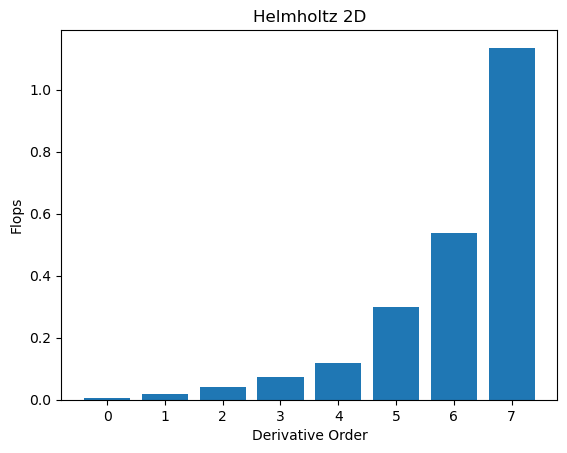

In [27]:
plt.bar([i for i in range(num_derivs)], timings)
plt.ylabel('Flops')
plt.xlabel('Derivative Order')
plt.title("Helmholtz 2D")

In [31]:
w = make_identity_diff_op(2)
helmholtz2d = laplacian(w) + w
n_init, _, r = get_processed_and_shifted_recurrence(helmholtz2d)

In [57]:
s=sp.Function('s')
n=sp.Symbol('n')

check = []
x_coord = abs(np.random.rand()*1)  # noqa: NPY002
y_coord = abs(np.random.rand()*1)  # noqa: NPY002
coord_dict = {var[0]: x_coord, var[1]: y_coord}

subs_dict = {s(0): dervis_helm[0].subs(coord_dict).evalf(), s(1): dervis_helm[1].subs(coord_dict).evalf()}

assert n_init == 2
for i in range(n_init, num_derivs):
    start = time.time()
    print(r.subs(n, i))
    res = abs(r.subs(n, i).subs(subs_dict).subs(coord_dict).evalf())
    end = time.time()
    check.append(end-start)
    # pylint: disable-next=not-callable
    subs_dict[s(i)] = res

-x0**2*s(0)/(x0**2 + x1**2) + (x0**2 - x1**2)*s(1)/(x0**3 + x0*x1**2)
3*x0**2*s(0)/(x0**3 + x0*x1**2) + 4*x0**2*s(2)/(x0**3 + x0*x1**2) - (x0**2 + 2)*s(1)/(x0**2 + x1**2)
-(x0**2 + 10)*s(2)/(x0**2 + x1**2) + (6*x0**2 + 2)*s(1)/(x0**3 + x0*x1**2) + (7*x0**2 + x1**2)*s(3)/(x0**3 + x0*x1**2) - 6*s(0)/(x0**2 + x1**2)
-(x0**2 + 24)*s(3)/(x0**2 + x1**2) + (9*x0**2 + 12)*s(2)/(x0**3 + x0*x1**2) + (10*x0**2 + 2*x1**2)*s(4)/(x0**3 + x0*x1**2) + 6*s(0)/(x0**3 + x0*x1**2) - 18*s(1)/(x0**2 + x1**2)
-(x0**2 + 44)*s(4)/(x0**2 + x1**2) + (12*x0**2 + 36)*s(3)/(x0**3 + x0*x1**2) + (13*x0**2 + 3*x1**2)*s(5)/(x0**3 + x0*x1**2) + 24*s(1)/(x0**3 + x0*x1**2) - 36*s(2)/(x0**2 + x1**2)
-(x0**2 + 70)*s(5)/(x0**2 + x1**2) + (15*x0**2 + 80)*s(4)/(x0**3 + x0*x1**2) + (16*x0**2 + 4*x1**2)*s(6)/(x0**3 + x0*x1**2) + 60*s(2)/(x0**3 + x0*x1**2) - 60*s(3)/(x0**2 + x1**2)


Text(0.5, 1.0, 'Helmholtz 2D')

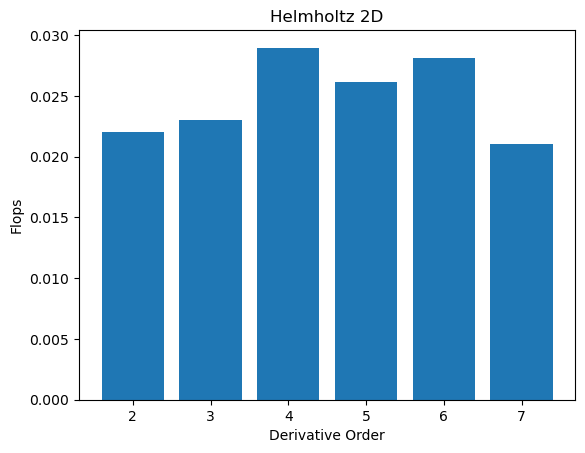

In [58]:
plt.bar([i for i in range(n_init, num_derivs)], check)
plt.ylabel('Flops')
plt.xlabel('Derivative Order')
plt.title("Helmholtz 2D")